In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

import pathlib
import re

def natural_key(string_):
    """See http://www.codinghorror.com/blog/archives/001018.html"""
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)]

In [2]:
def draw_organ(ax, array, color = 'b'):
    N = array.shape[0]
    for i in range(0, N):
        x, y = array[i,:]
        circ = plt.Circle((x, y), radius=3, color=color, fill = True)
        ax.add_patch(circ)
    return

def draw_lines(ax, array, color = 'b'):
    N = array.shape[0]
    for i in range(0, N):
        x1, y1 = array[i-1,:]
        x2, y2 = array[i,:]
        ax.plot([x1, x2], [y1, y2], color=color, linestyle='-', linewidth=1)
    return

def drawOrgans(RL, LL, H = None, img =  None):
    fig, ax = plt.subplots()
    
    if img is not None:
        plt.imshow(img, cmap='gray')
    else:
        img = np.zeros([1024, 1024])
        plt.imshow(img)
    
    plt.axis('off')
    
    draw_lines(ax, RL, 'r')
    draw_lines(ax, LL, 'g')
    
    draw_organ(ax, RL, 'r')
    draw_organ(ax, LL, 'g')
    
    if H is not None:
        draw_lines(ax, H, 'y')
        draw_organ(ax, H, 'y')

    return

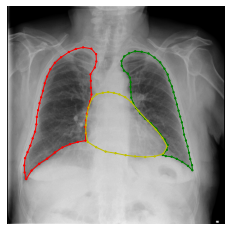

In [3]:
data_root = pathlib.Path("Images/")
all_files = list(data_root.glob('*.png'))
all_files = [str(path) for path in all_files]
all_files.sort(key = natural_key)

img1 = all_files[0]
RL = img1.replace('Images','landmarks/RL').replace('.png','.npy')
LL = img1.replace('Images','landmarks/LL').replace('.png','.npy')
H = img1.replace('Images','landmarks/H').replace('.png','.npy')

img = cv2.imread(img1,0)
RL = np.load(RL)
LL = np.load(LL)
H = np.load(H)

drawOrgans(RL,LL,H,img)

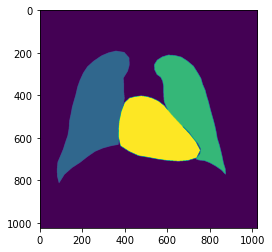

In [4]:
def getDenseMask(RL, LL, H = None, imagesize = 1024):
    img = np.zeros([1024,1024])
    
    RL = RL.reshape(-1, 1, 2).astype('int')
    LL = LL.reshape(-1, 1, 2).astype('int')

    img = cv2.drawContours(img, [RL], -1, 1, -1)
    img = cv2.drawContours(img, [LL], -1, 2, -1)
    
    if H is not None:
        H = H.reshape(-1, 1, 2).astype('int')
        img = cv2.drawContours(img, [H], -1, 3, -1)
    
    return img

aux = getDenseMask(RL,LL,H)
plt.imshow(aux)

In [5]:
import pandas as pd

clinical = pd.read_csv('clinical.csv')

N = clinical.shape[0]
nF = np.sum(clinical['Sex'] == 'F')
nM = np.sum(clinical['Sex'] == 'M')

print('Total of images with annotations:', N)
print('The dataset contains %s females and %s males'%(nF,nM))
print('The dataset contains %.2f%% females and %.2f%% males'%(nF/N * 100,nM/N * 100))

n1 = np.sum(clinical['Condition'] == 'normal') + np.sum(clinical['Condition'] == 'non-nodule')
n2 = np.sum(clinical['Dataset'] == 'Padchest')
n3 = np.sum(clinical['Dataset'] != 'Padchest') - n1

print('Healthy cases:', n1)
print('Heart related patologies:', n2)
print('Lung related patologies:', n3)

Total of images with annotations: 911
The dataset contains 413 females and 498 males
The dataset contains 45.33% females and 54.67% males
Healthy cases: 346
Heart related patologies: 137
Lung related patologies: 428


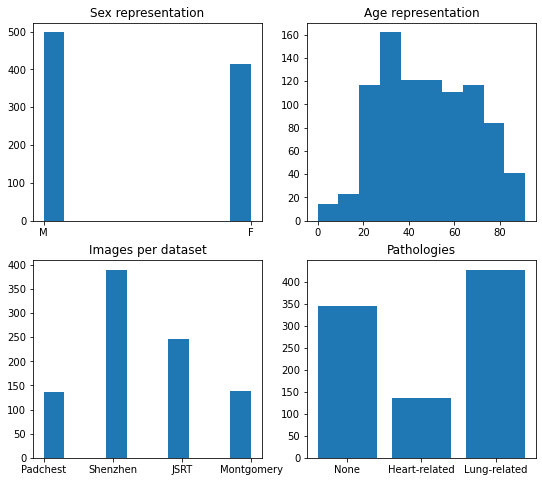

In [6]:
plt.figure(figsize = (9,8))
plt.subplot(2,2,1)
plt.hist(clinical['Sex'])
plt.title('Sex representation')

plt.subplot(2,2,2)
plt.hist(clinical['Age'])
plt.title('Age representation')

plt.subplot(2,2,3)
plt.hist(clinical['Dataset'])
plt.title('Images per dataset')

plt.subplot(2,2,4)
plt.title('Pathologies')
plt.bar(['None', 'Heart-related', 'Lung-related'], [n1,n2,n3])

plt.savefig('figs/info.png', transparent=False)

In [7]:
clinical['Lung area'] = 0
clinical['Age Group'] = 0

for i in range(clinical.shape[0]):
    file = clinical.iloc[i]['File']
    img1 = 'Images/' + file
    
    RL = img1.replace('Images','landmarks/RL').replace('.png','.npy')
    LL = img1.replace('Images','landmarks/LL').replace('.png','.npy')
    
    img = cv2.imread(img1,0)
    RL = np.load(RL)
    LL = np.load(LL)
    
    aux = getDenseMask(RL,LL,None) > 0

    clinical.loc[i, 'Lung area'] = np.sum(aux) / (1024*1024) * 100
    clinical.loc[i, 'Age Group'] = np.floor(clinical.iloc[i]['Age'] / 10) * 10

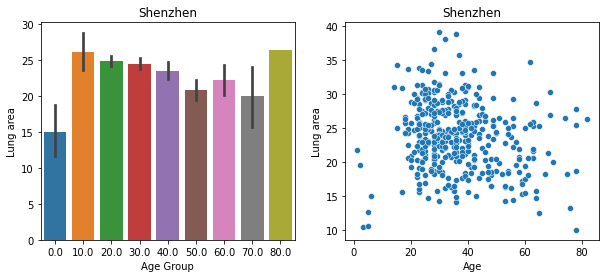

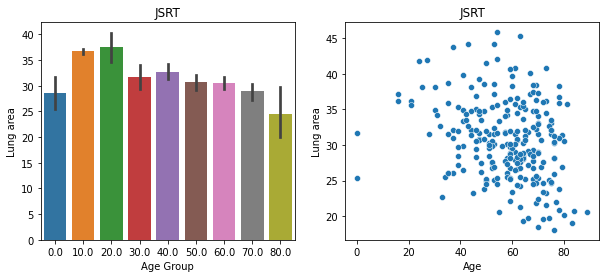

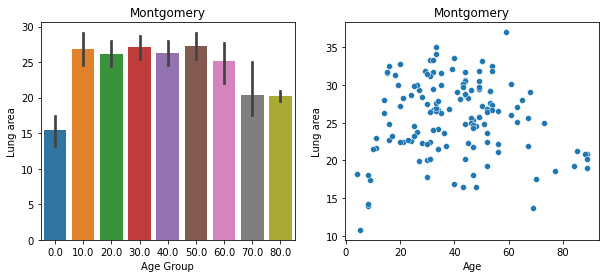

In [8]:
import seaborn as sns

for dataset in clinical.Dataset.unique():
    if dataset != 'Padchest':
        plt.figure(figsize = (10,4))

        plt.subplot(1,2,1)
        sns.barplot(x = 'Age Group', y = 'Lung area', data = clinical[clinical['Dataset']==dataset])
        plt.title(dataset)

        plt.subplot(1,2,2)
        sns.scatterplot(x = 'Age', y = 'Lung area', data = clinical[clinical['Dataset']==dataset])
        plt.title(dataset)
        plt.ylabel('Lung area')